# Model Analysis and Interpretation with DataManager

This notebook performs model analysis using the centralized DataManager approach:

1. **SHAP Value Analysis**: To understand feature importance and how features influence predictions.
2. **Outlier & High Residual Analysis**: Using SHAP to investigate instances where the model's predictions deviate significantly from actual values.
3. **Counterfactual Exploration**: Manually exploring how changing influential features impacts predictions for specific instances.
4. **Hyperparameter Quality Visualization**: Using Optuna's visualization tools to analyze hyperparameter tuning results.


In [1]:
import json
import logging
import os
import sys
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import shap 
import xgboost as xgb
from sklearn.model_selection import KFold

# Add project root to path for imports
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")
else:
    print(f"'{project_root}' already in sys.path.")

from src.config import load_config
from src.data_manager import DataManager

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.StreamHandler()],
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logging.getLogger("lightgbm").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)
shap.initjs()


/Users/sergiocarcamo/Dev/thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Added '/Users/sergiocarcamo/Dev/thesis' to sys.path for module imports.


## Configuration and MLflow Setup

Set up the configuration and MLflow experiment details.

**ACTION REQUIRED**:
- `SELECTED_FEATURES_FILENAME_FOR_ANALYSIS`: Set this to the name of the feature set JSON file (without .json extension)
- `MODEL_NAME_FOR_ANALYSIS`: Set this to the model type you want to analyze (e.g., `"LightGBM"`, `"XGBoost"`)
- `MLFLOW_RUN_ID_FOR_ANALYSIS` (Optional): If you know the specific MLflow Run ID for the "BEST" model run


In [2]:
# Load configuration
config_values = load_config()

# Basic configuration
TARGET_VARIABLE = config_values.get("TARGET_VARIABLE", "price")
RANDOM_STATE = config_values.get("RANDOM_STATE", 42)
SELECTED_FEATURES_DIR = config_values.get("SELECTED_FEATURES_DIR", "feature_sets")
MLFLOW_TRACKING_URI = mlflow.get_tracking_uri()

# Analysis configuration
SELECTED_FEATURES_FILENAME_FOR_ANALYSIS = "rfecv_all_nfeat_158_pca_count_loc" 
MODEL_NAME_FOR_ANALYSIS = "LightGBM"
MLFLOW_RUN_ID_FOR_ANALYSIS = None  # Set this if you have a specific run ID

# Construct paths and identifiers
selected_features_path_for_analysis = os.path.join(
    "..", SELECTED_FEATURES_DIR, f"{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}.json"
)

feature_set_identifier = SELECTED_FEATURES_FILENAME_FOR_ANALYSIS.replace(".json", "")
MLFLOW_EXPERIMENT_NAME = (
    f"RE price predictor - {TARGET_VARIABLE} - {feature_set_identifier}"
)

# Setup MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

logging.info(f"Using MLflow Tracking URI: {MLFLOW_TRACKING_URI}")
logging.info(f"Using MLflow Experiment: '{MLFLOW_EXPERIMENT_NAME}'")
logging.info(f"Analyzing model: {MODEL_NAME_FOR_ANALYSIS} with feature set: {SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}")


2025-06-18 02:01:31,567 - INFO - Using MLflow Tracking URI: file:///Users/sergiocarcamo/Dev/thesis/notebooks/mlruns
2025-06-18 02:01:31,569 - INFO - Using MLflow Experiment: 'RE price predictor - price - rfecv_all_nfeat_158_pca_count_loc'
2025-06-18 02:01:31,570 - INFO - Analyzing model: LightGBM with feature set: rfecv_all_nfeat_158_pca_count_loc


## Load Data Using DataManager

Load and transform the data using the centralized DataManager approach. This ensures consistency with the training pipeline.


In [3]:
# Initialize configuration with metadata and defaults
config = {
    "TARGET_VARIABLE": TARGET_VARIABLE,
    "RANDOM_STATE": RANDOM_STATE
}

# Initialize DataManager and load data
data_manager = DataManager(config)
data_manager.load_data()

# Get transformed data using the centralized method
X_train_transformed, X_test_transformed, feature_info = (
    data_manager.get_transformed_data_from_feature_set(selected_features_path_for_analysis)
)

# Get target variables
Y_train_log_transformed = data_manager.get_log_transformed_target()
Y_test_log_transformed = np.log(data_manager.get_test_target())

# Align test target to match test data indices
Y_test_log_transformed = Y_test_log_transformed.loc[X_test_transformed.index]

logging.info(f"✅ Data transformation completed")
logging.info(f"📊 Training data shape: {X_train_transformed.shape}")
logging.info(f"📊 Test data shape: {X_test_transformed.shape}")
logging.info(f"📋 Feature info: {feature_info}")

# Log effective parameters from metadata
logging.info(f"Effective parameters from metadata:")
logging.info(f"- APPLY_SCALE_TRANSFORM: {feature_info['feature_selection_metadata'].get('apply_scale_transform', False)}")
logging.info(f"- APPLY_PCA_IMG_TRANSFORM: {feature_info['feature_selection_metadata'].get('apply_pca_img_transform', False)}")
logging.info(f"- APPLY_UMAP_IMG_TRANSFORM: {feature_info['feature_selection_metadata'].get('apply_umap_img_transform', False)}")
logging.info(f"- N_PCA_COMPONENTS: {feature_info['feature_selection_metadata'].get('n_pca_components', 0.8)}")
logging.info(f"- N_UMAP_COMPONENTS: {feature_info['feature_selection_metadata'].get('n_umap_components', 50)}")
logging.info(f"- INCLUDE_LOCATION_FEATURES: {config.get('INCLUDE_LOCATION_FEATURES', False)}")
logging.info(f"- RANDOM_STATE: {config['RANDOM_STATE']}")


2025-06-18 02:01:31,576 - INFO - Loading and cleaning raw data for the first time...


Removing 7344 outliers from the dataset.


2025-06-18 02:01:53,981 - INFO - Splitting data into train/test sets...
2025-06-18 02:01:57,733 - INFO - Raw Train Data: (37316, 183), Raw Test Data: (9330, 183)
2025-06-18 02:01:57,738 - INFO - Raw Image Train Data: (37316, 1547), Raw Image Test Data: (9330, 1547)
2025-06-18 02:01:57,752 - INFO - Excluding location features ['district', 'neighborhood'] from categorical columns
2025-06-18 02:01:57,752 - INFO - Original Numeric Cols: 172
2025-06-18 02:01:57,760 - INFO - Original Categorical Cols: 7
2025-06-18 02:01:57,764 - INFO - Original Image Cols: 1547
2025-06-18 02:01:57,865 - INFO - Loaded 158 selected features from ../feature_sets/rfecv_all_nfeat_158_pca_count_loc.json
2025-06-18 02:01:57,866 - INFO - Feature selection metadata: {'method': 'rfecv', 'feature_subset_used': 'all', 'n_features_selected': 158, 'images_handled_separately': True, 'should_include_images': True, 'apply_pca_img_transform': True, 'apply_umap_img_transform': False, 'n_umap_components': None, 'n_pca_component

Created image transformer: PCA=True, UMAP=False
Processing interior image features: 1024 features
Applied PCA to interior: 1024 -> 50
Processing other_interior image features: 512 features
Applied PCA to other_interior: 512 -> 50
Processing exterior image features: 512 features
Applied PCA to exterior: 512 -> 50
Fitted image transformer
CombinedFeatureTransformer fitted with 158 selected features


2025-06-18 02:02:04,727 - INFO - 📷 Processing interior image features: 1024 features
2025-06-18 02:02:05,549 - INFO - 📷 Processing other_interior image features: 512 features
2025-06-18 02:02:05,803 - INFO - 📷 Processing exterior image features: 512 features


Combined features: 158 tabular + 161 image = 319 total


2025-06-18 02:02:07,217 - INFO - 📷 Processing interior image features: 1024 features
2025-06-18 02:02:07,331 - INFO - 📷 Processing other_interior image features: 512 features
2025-06-18 02:02:07,386 - INFO - 📷 Processing exterior image features: 512 features
2025-06-18 02:02:07,477 - INFO - 🖼️ Combined transformer: 158 tabular + 161 image = 319 total features
2025-06-18 02:02:07,478 - INFO - 🖼️ Image feature examples: ['interior_pca_0', 'interior_pca_1', 'interior_pca_2', 'interior_pca_3', 'interior_pca_4']...
2025-06-18 02:02:07,483 - INFO - ✅ Data transformation completed
2025-06-18 02:02:07,484 - INFO - 📊 Training data shape: (37316, 319)
2025-06-18 02:02:07,484 - INFO - 📊 Test data shape: (9330, 319)
2025-06-18 02:02:07,484 - INFO - 📋 Feature info: {'total_features': 319, 'tabular_features': 158, 'image_features': 161, 'selected_tabular_features': 158, 'feature_selection_metadata': {'method': 'rfecv', 'feature_subset_used': 'all', 'n_features_selected': 158, 'images_handled_separat

Combined features: 158 tabular + 161 image = 319 total


## Load Model from MLflow

Find and load the best model run from MLflow for analysis.


In [4]:
version = 'v5'
target_run_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_mape_{version}_BEST"
print(target_run_name)

mlflow.search_runs(
            search_all_experiments=True,
            filter_string=f"tags.mlflow.runName = '{target_run_name}' AND tags.run_type = 'best_run'",
            order_by=["metrics.test_final_mape ASC"],
            max_results=1
        )

LightGBM_rfecv_all_nfeat_158_pca_count_loc_mape_v5_BEST


,run_id,experiment_id,status,artifact_uri,start_time,end_time


In [6]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("file:///Users/sergiocarcamo/Dev/thesis/mlruns")

# Define version and target run name
target_run_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_mape_{version}_BEST"
print(target_run_name)

# Find the best run
if MLFLOW_RUN_ID_FOR_ANALYSIS is None:
    try:
        best_runs_df = mlflow.search_runs(
            search_all_experiments=True,
            filter_string=f"tags.mlflow.runName = '{target_run_name}' AND tags.run_type = 'best_run'",
            order_by=["metrics.test_final_mape ASC"],
            max_results=1
        )

        if best_runs_df.empty:
            print(target_run_name)
            raise ValueError(f"No 'best_run' found for {MODEL_NAME_FOR_ANALYSIS} with feature set {SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}")
        
        MLFLOW_RUN_ID_FOR_ANALYSIS = best_runs_df.iloc[0]["run_id"]
        logging.info(f"Found best run ID: {MLFLOW_RUN_ID_FOR_ANALYSIS}")
    except Exception as e:
        logging.error(f"Could not automatically find the best run: {e}")
        raise

# Define model artifact paths
model_artifact_path_sklearn = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/{MODEL_NAME_FOR_ANALYSIS}_pipeline"
model_artifact_path_native = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/{MODEL_NAME_FOR_ANALYSIS}_model"

# Load the model
loaded_model = None
actual_model = None

try:
    if MODEL_NAME_FOR_ANALYSIS in ["LightGBM", "XGBoost", "XGBoostQuantile"]:
        if MODEL_NAME_FOR_ANALYSIS == "LightGBM":
            try:
                logging.info(f"Trying to load LightGBM native model")
                actual_model = mlflow.lightgbm.load_model(model_artifact_path_native)
                logging.info(f"Successfully loaded native LightGBM model: {type(actual_model)}")
            except Exception as e:
                logging.warning(f"Failed to load native LightGBM model directly: {e}")
                logging.info(f"Falling back to pyfunc.load_model...")
                loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
                actual_model = loaded_model
        else:  # XGBoost models
            try:
                logging.info(f"Trying to load XGBoost native model")
                actual_model = mlflow.xgboost.load_model(model_artifact_path_native)
                logging.info(f"Successfully loaded native XGBoost model: {type(actual_model)}")
            except Exception as e:
                logging.warning(f"Failed to load native XGBoost model directly: {e}")
                logging.info(f"Falling back to pyfunc.load_model...")
                loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
                actual_model = loaded_model

        # Try sklearn pipeline if needed
        if actual_model is None:
            try:
                logging.info(f"Attempting to load as sklearn model/pipeline")
                sklearn_pipeline_model = mlflow.sklearn.load_model(model_artifact_path_sklearn)
                if hasattr(sklearn_pipeline_model, 'named_steps') and 'model' in sklearn_pipeline_model.named_steps:
                    actual_model = sklearn_pipeline_model.named_steps['model']
                else:
                    actual_model = sklearn_pipeline_model
                logging.info(f"Successfully loaded model from sklearn pipeline: {type(actual_model)}")
            except Exception as e_sklearn:
                logging.error(f"Failed to load as sklearn model/pipeline: {e_sklearn}")
                if actual_model is None:
                    raise ValueError(f"No model could be loaded for {MODEL_NAME_FOR_ANALYSIS}")

    else:  # RandomForest or other sklearn models
        logging.info(f"Loading {MODEL_NAME_FOR_ANALYSIS} as sklearn pipeline")
        sklearn_pipeline_model = mlflow.sklearn.load_model(model_artifact_path_sklearn)
        if hasattr(sklearn_pipeline_model, 'named_steps') and 'model' in sklearn_pipeline_model.named_steps:
            actual_model = sklearn_pipeline_model.named_steps['model']
        else:
            actual_model = sklearn_pipeline_model
        logging.info(f"Successfully loaded sklearn model: {type(actual_model)}")

    if actual_model is None:
        raise ValueError("Model was not successfully loaded into 'actual_model'")

    logging.info(f"✅ Successfully loaded model: {MODEL_NAME_FOR_ANALYSIS} (type: {type(actual_model)})")
    logging.info(f"🔗 MLflow Run ID: {MLFLOW_RUN_ID_FOR_ANALYSIS}")

except Exception as e:
    logging.error(f"Error loading model from MLflow run {MLFLOW_RUN_ID_FOR_ANALYSIS}: {e}")
    raise


2025-06-18 02:02:23,869 - INFO - Trying to load LightGBM native model


LightGBM_rfecv_all_nfeat_158_pca_count_loc_mape_v5_BEST


2025-06-18 02:02:43,049 - INFO - Successfully loaded native LightGBM model: <class 'lightgbm.sklearn.LGBMRegressor'>
2025-06-18 02:02:43,050 - INFO - ✅ Successfully loaded model: LightGBM (type: <class 'lightgbm.sklearn.LGBMRegressor'>)
2025-06-18 02:02:43,050 - INFO - 🔗 MLflow Run ID: 90e366264b474c9cb957049b5ee68018


## SHAP Analysis

Calculate and visualize SHAP values to understand feature contributions. We'll use the appropriate SHAP explainer based on the model type.


In [ ]:
# Configure SHAP logging
logging.getLogger('shap').setLevel(logging.WARNING)

# Check if model is a native tree model
is_native_tree_model = isinstance(actual_model, (lgb.Booster, lgb.LGBMRegressor,
                                               xgb.Booster, xgb.XGBRegressor))

def wrapped_predict_fn(data_input, model_to_predict, feature_columns):
    """Wraps the model's predict function to ensure input is a pandas DataFrame"""
    if isinstance(data_input, np.ndarray):
        data_input_df = pd.DataFrame(data_input, columns=feature_columns)
    elif isinstance(data_input, pd.DataFrame):
        data_input_df = data_input[feature_columns]
    else:
        raise TypeError(f"Unexpected input type for wrapped_predict_fn: {type(data_input)}")
    
    return model_to_predict.predict(data_input_df)

# Initialize SHAP explainer based on model type
if is_native_tree_model:
    try:
        if hasattr(actual_model, 'predict_proba') or hasattr(actual_model, 'predict'):
            explainer = shap.TreeExplainer(actual_model, data=X_test_transformed.sample(min(100, len(X_test_transformed))))
            logging.info(f"Using shap.TreeExplainer for native {MODEL_NAME_FOR_ANALYSIS} model.")
        else:
            raise TypeError(f"Model is not suitable for TreeExplainer")
    except Exception as tree_explainer_ex:
        logging.warning(f"Could not initialize TreeExplainer (Error: {tree_explainer_ex}). Falling back to KernelExplainer.")
        
        model_object_for_predict = actual_model if hasattr(actual_model, 'predict') else sklearn_pipeline_model
        if model_object_for_predict is None:
            raise ValueError("No suitable predict function found for SHAP KernelExplainer.")

        predict_fn_for_shap = lambda x: wrapped_predict_fn(x, model_object_for_predict, X_test_transformed.columns)
        
        # Use a sample of training data as background
        X_train_sample = X_train_transformed.sample(min(100, len(X_train_transformed)), random_state=RANDOM_STATE)
        explainer = shap.KernelExplainer(predict_fn_for_shap, X_train_sample)
        logging.info(f"Using shap.KernelExplainer for {MODEL_NAME_FOR_ANALYSIS}.")
else:
    logging.info(f"Using KernelExplainer as model is not a native tree model")
    
    X_train_sample = X_train_transformed.sample(min(100, len(X_train_transformed)), random_state=RANDOM_STATE)
    model_object_for_predict = actual_model if hasattr(actual_model, 'predict') else sklearn_pipeline_model
    
    predict_fn_for_shap = lambda x: wrapped_predict_fn(x, model_object_for_predict, X_test_transformed.columns)
    explainer = shap.KernelExplainer(predict_fn_for_shap, X_train_sample)

# Calculate SHAP values
import os
import pickle

os.makedirs("shap_values", exist_ok=True)
shap_values_file_path = f"shap_values/shap_values_{target_run_name}.pkl"

if not os.path.exists(shap_values_file_path):
    shap_values_test = explainer.shap_values(X_test_transformed)
    with open(shap_values_file_path, "wb") as f:
        pickle.dump(shap_values_test, f)
    logging.info("SHAP values calculated and saved.")
else:
    with open(shap_values_file_path, "rb") as f:
        shap_values_test = pickle.load(f)
    logging.info("SHAP values loaded from file.")


2025-06-18 01:41:19,857 - INFO - Using shap.TreeExplainer for native LightGBM model.
 13%|===                 | 1177/9330 [19:57<138:11]       

: 

: 

### Global Feature Importance (Bar Plot)
This plot shows the average magnitude of SHAP values for each feature, indicating their overall importance in the model's predictions.


In [7]:
import shap

explainer = shap.TreeExplainer(actual_model, feature_perturbation="tree_path_dependent")



NameError: name 'shap_values_file_path' is not defined

In [ ]:
import os
import pickle

os.makedirs("shap_values", exist_ok=True)
shap_values_file_path = f"shap_values/shap_values_{target_run_name}.pkl"


if not os.path.exists(shap_values_file_path):
    shap_values_test = explainer.shap_values(X_test_transformed)
    with open(shap_values_file_path, "wb") as f:
        pickle.dump(shap_values_test, f)
    logging.info("SHAP values calculated and saved.")
else:
    with open(shap_values_file_path, "rb") as f:
        shap_values_test = pickle.load(f)
    logging.info("SHAP values loaded from file.")



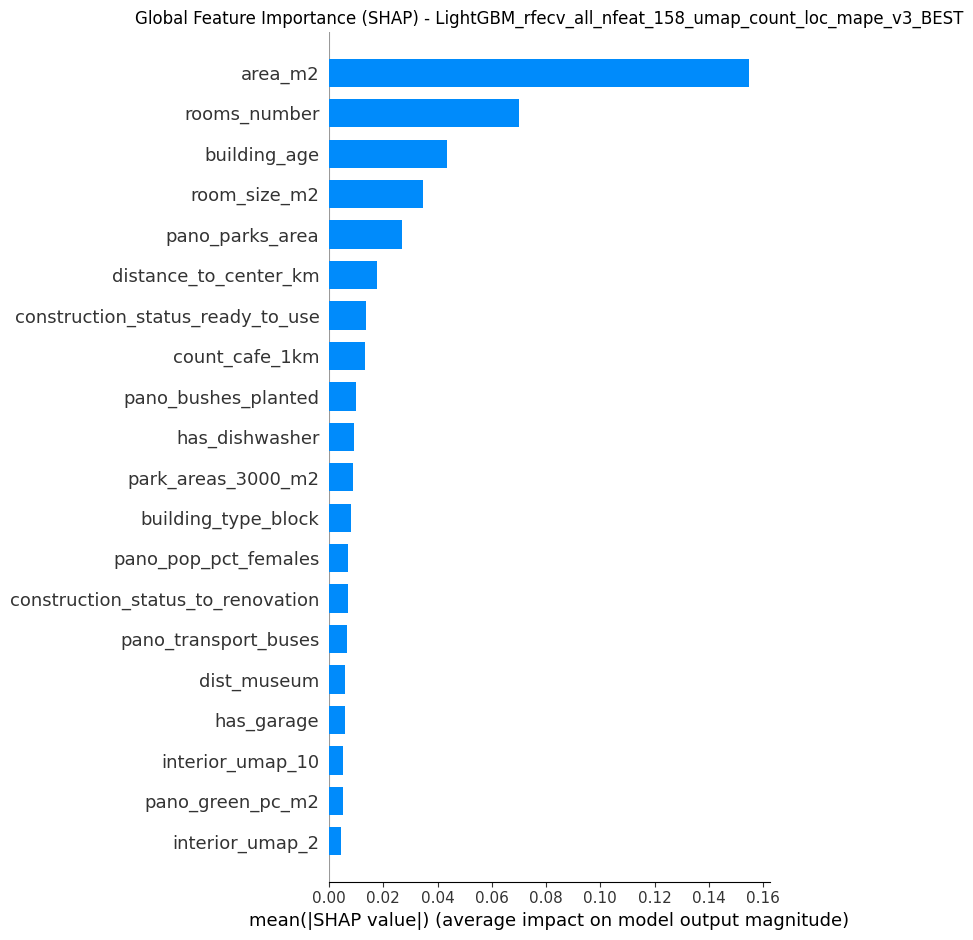

In [17]:
# Create global feature importance plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_test, X_test_transformed, plot_type="bar", show=False)
plt.title(f"Global Feature Importance (SHAP) - {target_run_name}")
plt.tight_layout()
plt.show()


### SHAP Summary Plot (Beeswarm)

This plot shows feature importance and impact. Each dot represents a data point, with color indicating feature value (red=high, blue=low). The x-axis shows the SHAP value impact.


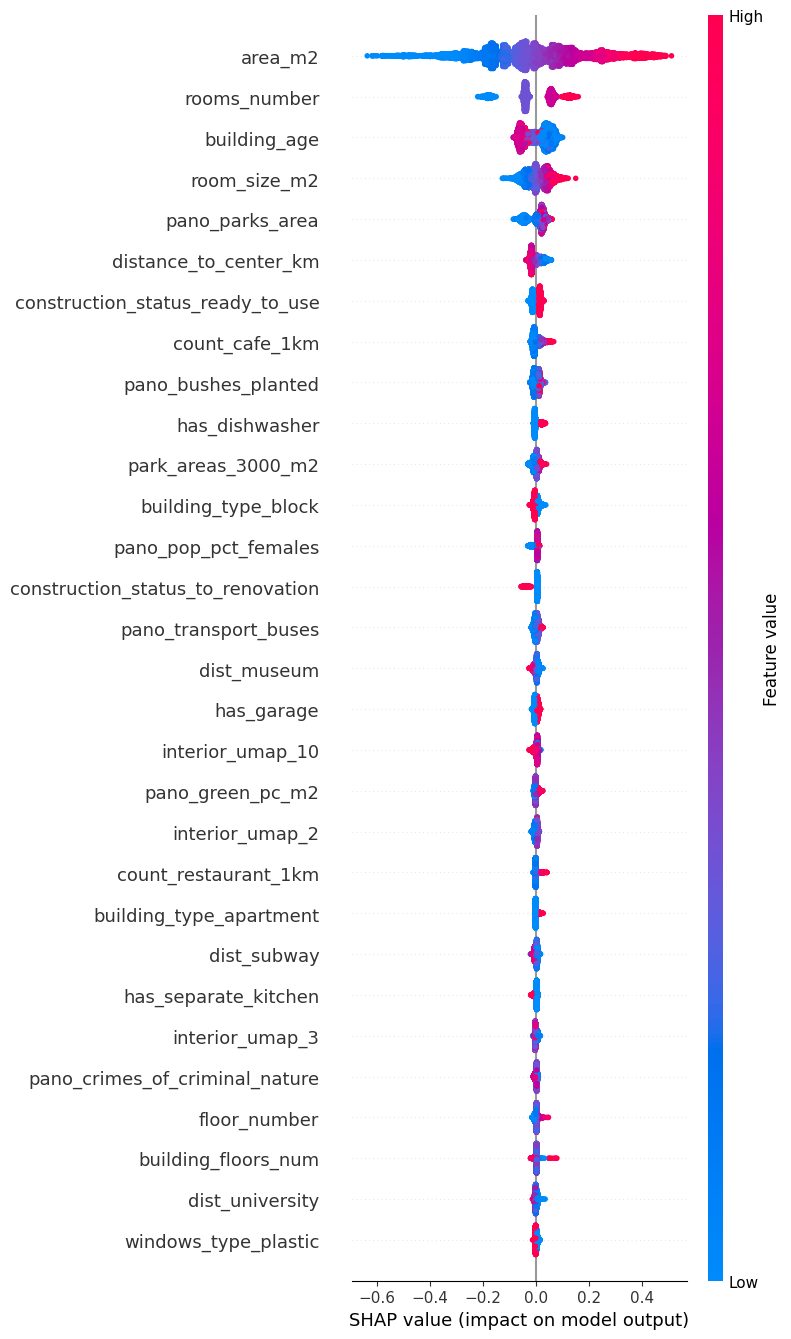

In [24]:
# Create beeswarm plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_test, X_test_transformed, show=False, max_display=30)
plt.tight_layout()
plt.show()


In [23]:
X_test_transformed.columns

Index(['is_private_owner', 'area_m2', 'floor_number', 'building_floors_num',
       'has_lift', 'has_internet', 'has_furniture', 'has_air_conditioning',
       'has_tv', 'has_oven',
       ...
       'exterior_umap_10', 'exterior_umap_11', 'exterior_umap_12',
       'exterior_umap_13', 'exterior_umap_14', 'exterior_umap_15',
       'exterior_umap_16', 'exterior_umap_17', 'exterior_umap_18',
       'exterior_umap_19'],
      dtype='object', length=218)

2025-06-17 09:32:24,036 - INFO - Generating dependence plots for features: ['area_m2', 'rooms_number', 'building_age', 'room_size_m2', 'pano_parks_area', 'interior_umap_10', 'interior_umap_2', 'interior_umap_3', 'exterior_umap_2']


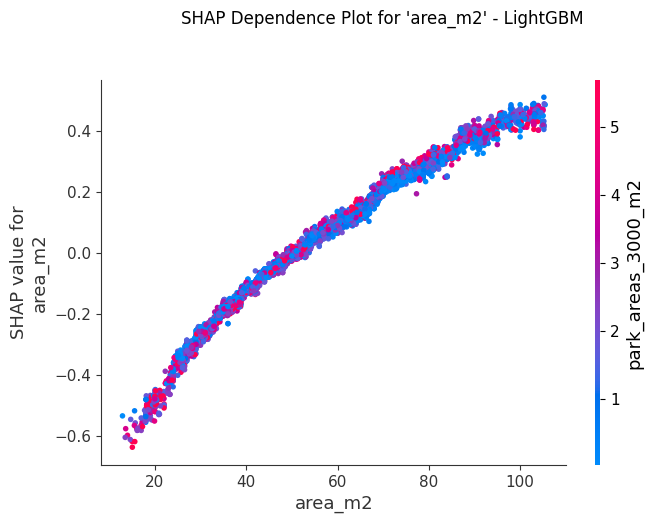

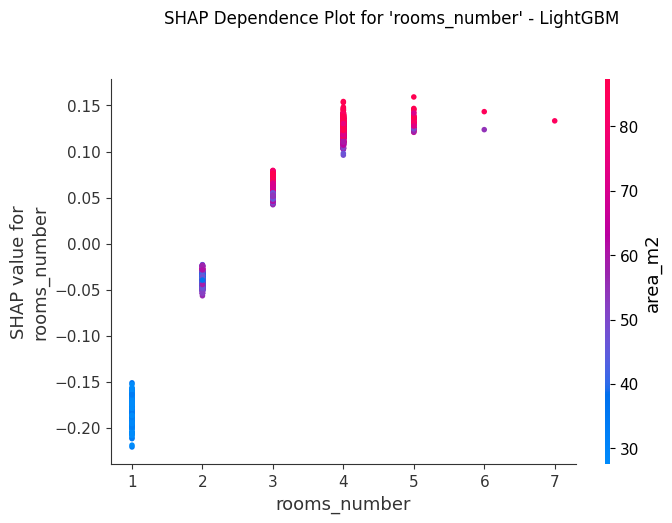

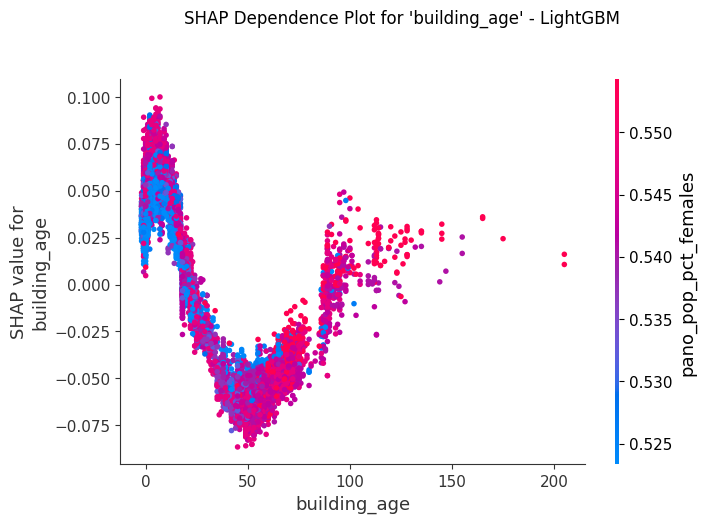

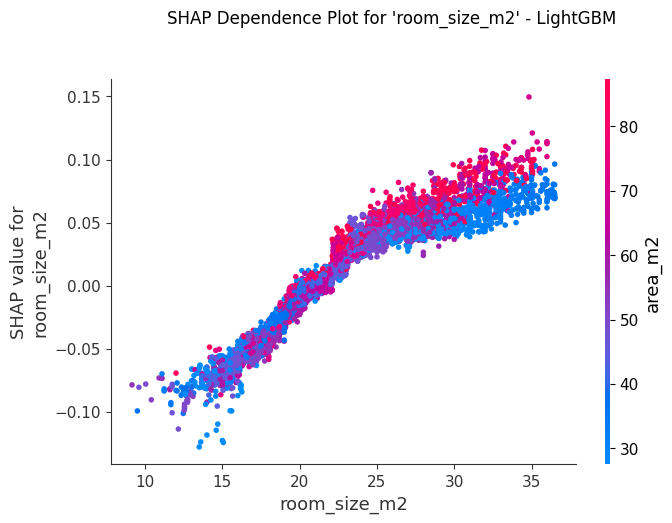

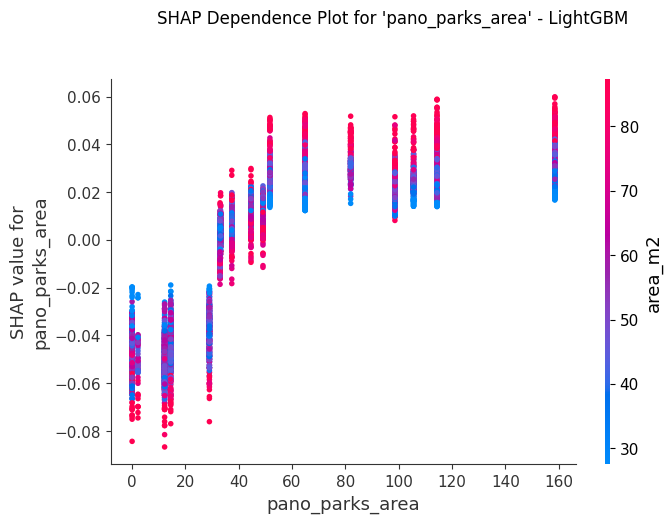

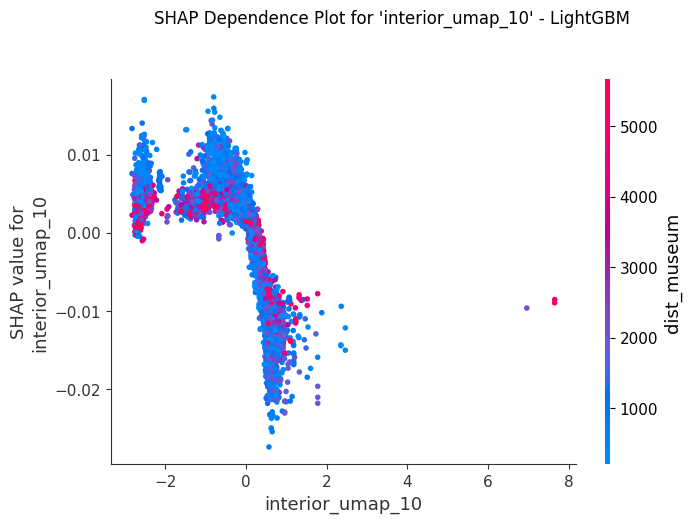

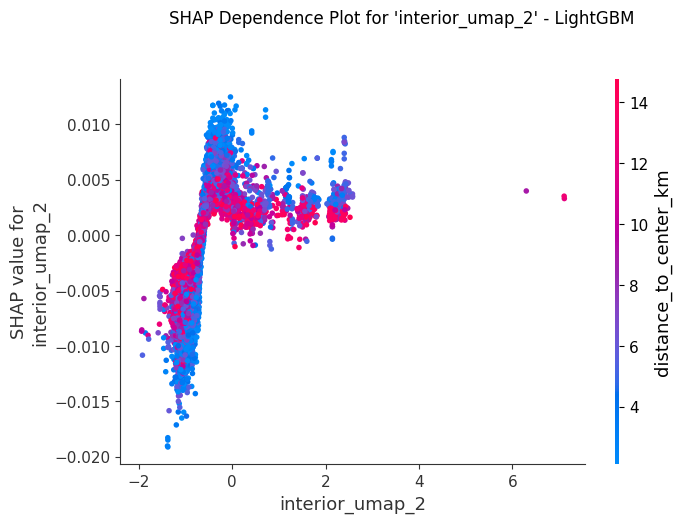

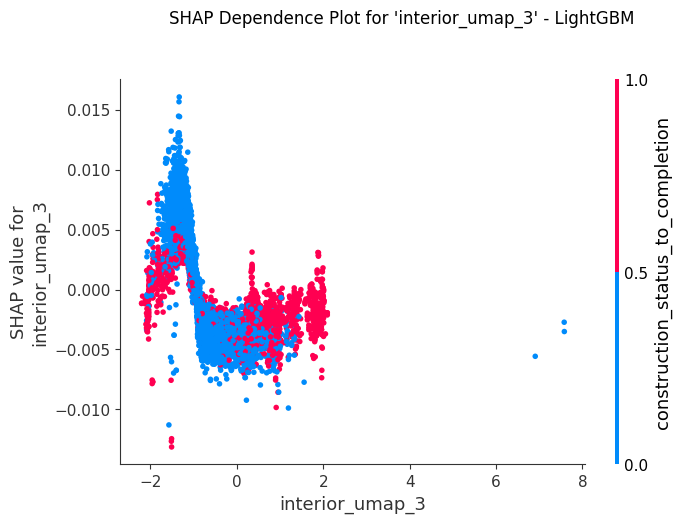

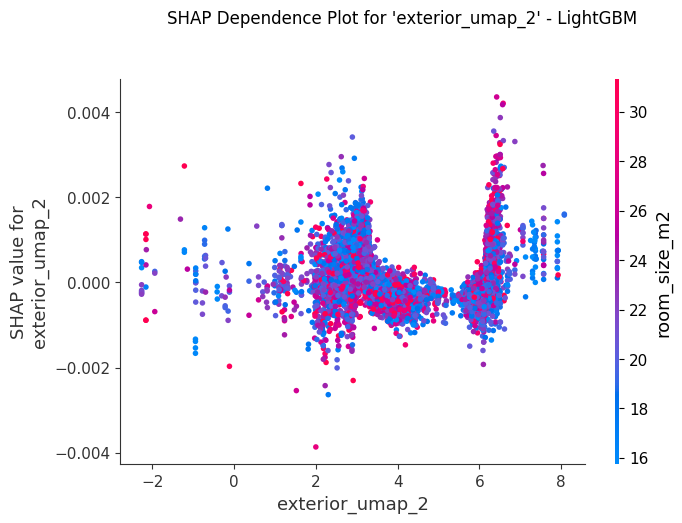

In [25]:
final_selected_feature_names_for_model = X_test_transformed.columns
if len(final_selected_feature_names_for_model) > 0:
    num_dependence_plots = min(5, len(final_selected_feature_names_for_model))
    
    mean_abs_shap = np.abs(shap_values_test).mean(0)
    if isinstance(X_test_transformed, pd.DataFrame):
        feature_names_for_plot = X_test_transformed.columns
    else: 
        feature_names_for_plot = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

    top_feature_indices = np.argsort(mean_abs_shap)[::-1][:num_dependence_plots]
    features_to_plot = [feature_names_for_plot[i] for i in top_feature_indices]
    features_to_plot += ['interior_umap_10', 'interior_umap_2', 'interior_umap_3', 'exterior_umap_2']
    
    logging.info(f"Generating dependence plots for features: {features_to_plot}")

    for feature_name in features_to_plot:
        try:
            shap.dependence_plot(
                feature_name,
                shap_values_test,
                X_test_transformed,
                interaction_index="auto", # Automatically picks an interaction feature
                show=False
            )
            plt.suptitle(f"SHAP Dependence Plot for '{feature_name}' - {MODEL_NAME_FOR_ANALYSIS}", y=1.02)
            plt.show()
        except Exception as e:
            logging.warning(f"Could not generate dependence plot for {feature_name}: {e}")
else:
    logging.warning("No features available to generate dependence plots.")

In [ ]:
# Make predictions
if hasattr(actual_model, 'predict'):
    Y_predict_log_test = actual_model.predict(X_test_transformed)
else:
    Y_predict_log_test = sklearn_pipeline_model.predict(X_test_transformed)

# Convert predictions back to original scale
Y_predict_orig_test = np.exp(Y_predict_log_test)
Y_true_orig_test = np.exp(Y_test_log_transformed)

# Calculate residuals
residuals_df = pd.DataFrame({
    'true_price': Y_true_orig_test,
    'predicted_price': Y_predict_orig_test,
    'residual': Y_true_orig_test - Y_predict_orig_test,
    'abs_residual': np.abs(Y_true_orig_test - Y_predict_orig_test),
    'pct_error': (np.abs(Y_true_orig_test - Y_predict_orig_test) / Y_true_orig_test) * 100
}, index=X_test_transformed.index)

# Sort by absolute residual
residuals_df = residuals_df.sort_values(by='abs_residual', ascending=False)

# Add error categories
residuals_df['error_category'] = 'medium_error'
high_error_threshold = residuals_df['abs_residual'].quantile(0.99)
low_error_threshold = residuals_df['abs_residual'].quantile(0.98)

residuals_df.loc[residuals_df['abs_residual'] >= high_error_threshold, 'error_category'] = 'high_error'
residuals_df.loc[residuals_df['abs_residual'] <= low_error_threshold, 'error_category'] = 'low_error'

# Add percentage-based error categories
residuals_df['error_category_pct'] = 'medium_error'
residuals_df.loc[residuals_df['pct_error'] >= 10, 'error_category_pct'] = 'high_error'
residuals_df.loc[residuals_df['pct_error'] < 5, 'error_category_pct'] = 'low_error'

# Display summary statistics
print("Error Category Distribution:")
display(residuals_df['error_category'].value_counts())

print("\nPercentage-based Error Category Distribution:")
display(residuals_df['error_category_pct'].value_counts())

print("\nTop 5 instances with highest absolute residuals:")
display(residuals_df.head())


In [ ]:
# Create scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(data=residuals_df, x='true_price', y='predicted_price', alpha=0.3)
plt.plot([residuals_df['true_price'].min(), residuals_df['true_price'].max()], 
         [residuals_df['true_price'].min(), residuals_df['true_price'].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True vs Predicted Prices')
plt.legend()
plt.show()

# Create residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=residuals_df, x='predicted_price', y='residual', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Values')
plt.show()


In [ ]:
# Get mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values_test).mean(0)
feature_importance_df = pd.DataFrame({
    'feature_name': X_test_transformed.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

# Select top features for dependence plots
num_dependence_plots = 5
top_features = feature_importance_df.head(num_dependence_plots)['feature_name'].tolist()

# Add some specific features of interest if they exist
interesting_features = ['pca0', 'pca1', 'area_m2', 'building_age']
features_to_plot = top_features + [f for f in interesting_features if f in X_test_transformed.columns]

# Create dependence plots
for feature_name in features_to_plot:
    try:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_name,
            shap_values_test,
            X_test_transformed,
            interaction_index="auto",
            show=False
        )
        plt.title(f"SHAP Dependence Plot for '{feature_name}' - {MODEL_NAME_FOR_ANALYSIS}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.warning(f"Could not generate dependence plot for {feature_name}: {e}")

# Print feature importance summary
print(f"\nTop {num_dependence_plots} Features Based on Mean Absolute SHAP Values:")
print("=" * 60)
for i, (idx, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. {row['feature_name']:<40} {row['mean_abs_shap']:.6f}")

print(f"\nTotal features in model: {len(feature_importance_df)}")
print(f"Top {num_dependence_plots} features account for {top_features['mean_abs_shap'].sum() / feature_importance_df['mean_abs_shap'].sum() * 100:.1f}% of total SHAP importance")


## Residual Analysis

Analyze instances where the model's predictions deviate significantly from actual values.
